In [1]:
import numpy as np 
import pandas as pd
import sklearn
import time
import os
import shap
import re, pip, conda
import seaborn as sns # 用于特征重要性柱状图 Seaborn默认的图形样式和调色板使得绘图更美观，无需手动调整样式
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve # 使用 roc_curve 函数计算 ROC 曲线的 FPR 和 TPR，并将这些数据存储为 pandas DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from bayes_opt import BayesianOptimization
from sklearn.gaussian_process.kernels import Matern




Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# 读取数据
data1 = pd.read_excel(r'D:\Users\刘洋\Desktop\测试负2.xlsx')
X = data1.iloc[:, 1:12].values  # 取除最后一列之外的所有列作为特征
y = data1.iloc[:, 12].values   # 最后一列为标签

In [3]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# 自定义评分标准
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

In [6]:
# 定义模型和贝叶斯优化的搜索空间
# 优化 XGBoost
def optimize_xgboost():
    def xgb_cv(max_depth, learning_rate, n_estimators, subsample, reg_lambda, gamma, min_child_weight, colsample_bytree):
        model = XGBClassifier(
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            subsample=subsample,
            reg_lambda=reg_lambda,
            gamma=gamma,
            min_child_weight=int(min_child_weight),
            colsample_bytree=colsample_bytree,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        scores = cross_validate(model, X_train, y_train, cv=3, scoring='roc_auc')['test_score']
        return scores.mean() if not np.isnan(scores).any() else 0
    
    xgb_bo = BayesianOptimization(
        xgb_cv,
        {
            'max_depth': (3, 10),
            'learning_rate': (0.01, 0.3),
            'n_estimators': (50, 300),
            'subsample': (0.5, 1.0),
            'reg_lambda': (0, 10),
            'gamma': (0, 5),
            'min_child_weight': (1, 10),
            'colsample_bytree': (0.5, 1.0)
        },
        random_state=42
    )
    xgb_bo.maximize(init_points=5, n_iter=25)
    return xgb_bo.max['params']

In [7]:
# 优化 LightGBM
def optimize_lightgbm():
    def lgb_cv(max_depth, learning_rate, n_estimators, subsample, reg_lambda, min_child_samples, colsample_bytree, reg_alpha):
        model = LGBMClassifier(
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            subsample=subsample,
            reg_lambda=reg_lambda,
            min_child_samples=int(min_child_samples),  # 转换为整数
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            use_label_encoder=False
        )
        scores = cross_validate(model, X_train, y_train, cv=3, scoring='roc_auc')['test_score']
        return scores.mean() if not np.isnan(scores).any() else 0
    
    lgb_bo = BayesianOptimization(
        lgb_cv,
        {
            'max_depth': (3, 8),
            'learning_rate': (0.01, 0.3),
            'n_estimators': (50, 300),
            'subsample': (0.5, 1.0),
            'reg_lambda': (0, 10),
            'min_child_samples': (5, 50),  # 确保范围是整数
            'colsample_bytree': (0.5, 1.0),
            'reg_alpha': (0, 10)
        },
        random_state=42
    )
    lgb_bo.maximize(init_points=5, n_iter=25)
    return lgb_bo.max['params']

In [8]:
# 优化 CatBoost
def optimize_catboost():
    def cat_cv(depth, learning_rate, iterations, od_wait, l2_leaf_reg, bagging_temperature, colsample_bylevel):
        model = CatBoostClassifier(
            depth=int(depth),
            learning_rate=learning_rate,
            iterations=int(iterations),
            od_wait=int(od_wait),  # 确保为整数
            l2_leaf_reg=l2_leaf_reg,
            bagging_temperature=bagging_temperature,
            colsample_bylevel=colsample_bylevel,
          
            verbose=0
        )
        scores = cross_validate(model, X_train, y_train, cv=10, scoring='roc_auc')['test_score']
        return scores.mean() if not np.isnan(scores).any() else 0
    
    cat_bo = BayesianOptimization(
        cat_cv,
        {
            'depth': (1, 15),
            'learning_rate': (0.01, 0.1),   #修改了上限值
            'iterations': (50, 500),   #修改了上限值
            'od_wait': (10, 100),  # 设置整数范围
            'l2_leaf_reg': (1, 10),
            'bagging_temperature': (0, 1),
            'colsample_bylevel': (0.5, 1.0),
            
        },
        random_state=42,
       
    )
    cat_bo.maximize(init_points=10, n_iter=25)
    return cat_bo.max['params']

In [9]:
# 优化 NGBoost
def optimize_ngboost():
    def ngb_cv(n_estimators, learning_rate, minibatch_frac, natural_gradient):
        model = NGBClassifier(
            n_estimators=int(n_estimators),
            learning_rate=learning_rate,
            minibatch_frac=minibatch_frac,
            natural_gradient=bool(natural_gradient)
        )
        scores = cross_validate(model, X_train, y_train, cv=5, scoring='roc_auc')['test_score']
        return scores.mean() if not np.isnan(scores).any() else 0
    
    ngb_bo = BayesianOptimization(
        ngb_cv,
        {
            'n_estimators': (50, 300),           # 将范围适当减小
            'learning_rate': (0.01, 0.1),       # 减小学习率范围
            'minibatch_frac': (0.7, 1.0),        # 增加批次采样比例的下限
            'natural_gradient': (0, 1)           # 0 表示 False，1 表示 True
        },
        random_state=42,
        verbose=2               
    )

    # 使用 Matern 核函数增加高斯过程稳定性
    ngb_bo.set_gp_params(kernel=Matern())
    
    ngb_bo.maximize(init_points=15, n_iter=10)
    return ngb_bo.max['params']

In [10]:
# 执行贝叶斯优化并输出最优参数
optimal_params = {
    "XGBoost": optimize_xgboost(),
    "LGBM": optimize_lightgbm(),
    "CatBoost": optimize_catboost(),
    "NGBoost": optimize_ngboost()
}

# 将相关参数转换为整数
for model_name in optimal_params:
    if "max_depth" in optimal_params[model_name]:
        optimal_params[model_name]["max_depth"] = int(optimal_params[model_name]["max_depth"])
    if "n_estimators" in optimal_params[model_name]:
        optimal_params[model_name]["n_estimators"] = int(optimal_params[model_name]["n_estimators"])
    if "iterations" in optimal_params[model_name]:
        optimal_params[model_name]["iterations"] = int(optimal_params[model_name]["iterations"])
    if "depth" in optimal_params[model_name]:
        optimal_params[model_name]["depth"] = int(optimal_params[model_name]["depth"])
    if "min_child_samples" in optimal_params[model_name]:
        optimal_params[model_name]["min_child_samples"] = int(optimal_params[model_name]["min_child_samples"])
    if "od_wait" in optimal_params[model_name]:
        optimal_params[model_name]["od_wait"] = int(optimal_params[model_name]["od_wait"])


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8115    | 0.6873    | 4.754     | 0.2223    | 7.191     | 2.404     | 89.0      | 0.5808    | 0.9331    |
| 2         | 0.7939    | 0.8006    | 3.54      | 0.01597   | 9.789     | 8.492     | 103.1     | 1.818     | 0.5917    |
| 3         | 0.8223    | 0.6521    | 2.624     | 0.1353    | 5.039     | 6.507     | 84.87     | 2.921     | 0.6832    |
| 4         | 0.8035    | 0.728     | 3.926     | 0.06791   | 6.6       | 6.332     | 61.61     | 6.075     | 0.5853    |
| 5         | 0.8072    | 0.5325    | 4.744     | 0.29      | 8.659     | 3.742     | 74.42     | 6.842     | 0.7201    |
| 6         | 0.8139    | 0.8222    | 0.1361    | 0.1822    | 4.984     | 7.025     | 85.4      | 7.358     | 0.8228    |
| 7         | 0.8093    

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1512 val_loss=0.0000 scale=0.5000 norm=0.6108
[iter 0] loss=0.6910 val_loss=0.0000 scale=4.0000 norm=7.9934
[iter 100] loss=0.1458 val_loss=0.0000 scale=1.0000 norm=1.2185


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1261 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6930 val_loss=0.0000 scale=4.0000 norm=8.0043
[iter 100] loss=0.1541 val_loss=0.0000 scale=0.0001 norm=0.0002


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1404 val_loss=0.0000 scale=0.1250 norm=0.1523
[iter 0] loss=0.6925 val_loss=0.0000 scale=4.0000 norm=7.9981
[iter 100] loss=0.1555 val_loss=0.0000 scale=0.2500 norm=0.3065


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1323 val_loss=0.0000 scale=0.5000 norm=0.5993
| 1         | 0.0       | 0.04371   | 0.9852    | 233.0     | 0.5987    |
[iter 0] loss=0.6934 val_loss=0.0000 scale=4.0000 norm=8.0040
[iter 0] loss=0.6883 val_loss=0.0000 scale=4.0000 norm=7.9717
[iter 0] loss=0.6966 val_loss=0.0000 scale=8.0000 norm=16.0764


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0051
[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=7.9953
| 2         | 0.0       | 0.02404   | 0.7468    | 64.52     | 0.8662    |
[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=7.9938
[iter 0] loss=0.6915 val_loss=0.0000 scale=2.0000 norm=3.9989


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6899 val_loss=0.0000 scale=4.0000 norm=7.9844
[iter 0] loss=0.6923 val_loss=0.0000 scale=4.0000 norm=7.9989
[iter 0] loss=0.6926 val_loss=0.0000 scale=4.0000 norm=7.9993
| 3         | 0.0       | 0.0641    | 0.9124    | 55.15     | 0.9699    |
[iter 0] loss=0.6923 val_loss=0.0000 scale=4.0000 norm=7.9953


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6879 val_loss=0.0000 scale=4.0000 norm=7.9691
[iter 0] loss=0.6859 val_loss=0.0000 scale=8.0000 norm=15.9058


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6935 val_loss=0.0000 scale=4.0000 norm=8.0081
[iter 0] loss=0.6916 val_loss=0.0000 scale=4.0000 norm=7.9909
| 4         | 0.0       | 0.08492   | 0.7637    | 95.46     | 0.1834    |
[iter 0] loss=0.6932 val_loss=0.0000 scale=4.0000 norm=8.0024
[iter 100] loss=0.0814 val_loss=0.0000 scale=0.5000 norm=0.5597
[iter 0] loss=0.6877 val_loss=0.0000 scale=2.0000 norm=3.9837
[iter 100] loss=0.1445 val_loss=0.0000 scale=2.0000 norm=2.4192
[iter 0] loss=0.6895 val_loss=0.0000 scale=4.0000 norm=7.9818


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1288 val_loss=0.0000 scale=1.0000 norm=1.1824
[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=8.0032
[iter 100] loss=0.1245 val_loss=0.0000 scale=0.5000 norm=0.5910
[iter 0] loss=0.6936 val_loss=0.0000 scale=4.0000 norm=8.0069


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1254 val_loss=0.0000 scale=0.5000 norm=0.5943
| 5         | 0.0       | 0.03738   | 0.8574    | 158.0     | 0.2912    |
[iter 0] loss=0.6925 val_loss=0.0000 scale=4.0000 norm=7.9968
[iter 100] loss=0.0679 val_loss=0.0000 scale=0.5000 norm=0.5490
[iter 0] loss=0.6924 val_loss=0.0000 scale=4.0000 norm=8.0049


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.0885 val_loss=0.0000 scale=1.0000 norm=1.1257
[iter 0] loss=0.6935 val_loss=0.0000 scale=4.0000 norm=8.0132
[iter 100] loss=0.0981 val_loss=0.0000 scale=0.5000 norm=0.5671
[iter 0] loss=0.6916 val_loss=0.0000 scale=4.0000 norm=7.9932


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1177 val_loss=0.0000 scale=0.5000 norm=0.5893
[iter 0] loss=0.6918 val_loss=0.0000 scale=4.0000 norm=7.9928
[iter 100] loss=0.1071 val_loss=0.0000 scale=2.0000 norm=2.3241
| 6         | 0.0       | 0.06507   | 0.7418    | 123.0     | 0.3664    |
[iter 0] loss=0.6934 val_loss=0.0000 scale=4.0000 norm=8.0040


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6920 val_loss=0.0000 scale=4.0000 norm=8.0018
[iter 0] loss=0.6928 val_loss=0.0000 scale=4.0000 norm=8.0084
[iter 0] loss=0.6927 val_loss=0.0000 scale=4.0000 norm=8.0016


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=8.0014
| 7         | 0.0       | 0.05105   | 0.9356    | 99.92     | 0.5142    |
[iter 0] loss=0.6920 val_loss=0.0000 scale=4.0000 norm=7.9928
[iter 100] loss=0.0658 val_loss=0.0000 scale=1.0000 norm=1.0947
[iter 200] loss=0.0663 val_loss=0.0000 scale=0.5000 norm=0.5489
[iter 0] loss=0.6923 val_loss=0.0000 scale=4.0000 norm=8.0042
[iter 100] loss=0.0857 val_loss=0.0000 scale=0.2500 norm=0.2808
[iter 200] loss=0.0614 val_loss=0.0000 scale=0.2500 norm=0.2694
[iter 0] loss=0.6934 val_loss=0.0000 scale=4.0000 norm=8.0129


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.0939 val_loss=0.0000 scale=1.0000 norm=1.1453
[iter 200] loss=0.0658 val_loss=0.0000 scale=0.5000 norm=0.5469
[iter 0] loss=0.6938 val_loss=0.0000 scale=4.0000 norm=8.0110
[iter 100] loss=0.0876 val_loss=0.0000 scale=1.0000 norm=1.1293


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.0733 val_loss=0.0000 scale=2.0000 norm=2.2277
[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=7.9948
[iter 100] loss=0.0918 val_loss=0.0000 scale=2.0000 norm=2.2531
[iter 200] loss=0.0704 val_loss=0.0000 scale=2.0000 norm=2.1922
| 8         | 0.0       | 0.06332   | 0.7139    | 201.9     | 0.1705    |


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6927 val_loss=0.0000 scale=4.0000 norm=7.9986
[iter 100] loss=0.1624 val_loss=0.0000 scale=1.0000 norm=1.2535
[iter 200] loss=0.1311 val_loss=0.0000 scale=0.5000 norm=0.6065
[iter 0] loss=0.6921 val_loss=0.0000 scale=2.0000 norm=4.0013
[iter 100] loss=0.2283 val_loss=0.0000 scale=2.0000 norm=2.6572


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1874 val_loss=0.0000 scale=1.0000 norm=1.2722
[iter 0] loss=0.6913 val_loss=0.0000 scale=4.0000 norm=7.9964
[iter 100] loss=0.1885 val_loss=0.0000 scale=1.0000 norm=1.2772


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1548 val_loss=0.0000 scale=0.2500 norm=0.3076
[iter 0] loss=0.6927 val_loss=0.0000 scale=4.0000 norm=8.0020
[iter 100] loss=0.2088 val_loss=0.0000 scale=2.0000 norm=2.6229


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1708 val_loss=0.0000 scale=0.5000 norm=0.6314
[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=8.0016
[iter 100] loss=0.2121 val_loss=0.0000 scale=2.0000 norm=2.6245


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1696 val_loss=0.0000 scale=2.0000 norm=2.5055
| 9         | 0.0       | 0.01585   | 0.9847    | 291.4     | 0.8084    |
[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=8.0003
[iter 100] loss=0.1196 val_loss=0.0000 scale=0.5000 norm=0.5955


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.0676 val_loss=0.0000 scale=1.0000 norm=1.1092
[iter 0] loss=0.6956 val_loss=0.0000 scale=4.0000 norm=8.0301
[iter 100] loss=0.1300 val_loss=0.0000 scale=2.0000 norm=2.3724
[iter 200] loss=0.0954 val_loss=0.0000 scale=0.5000 norm=0.5744


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6881 val_loss=0.0000 scale=2.0000 norm=3.9853
[iter 100] loss=0.1110 val_loss=0.0000 scale=2.0000 norm=2.3055
[iter 200] loss=0.0698 val_loss=0.0000 scale=1.0000 norm=1.0958
[iter 0] loss=0.6931 val_loss=0.0000 scale=8.0000 norm=16.0099
[iter 100] loss=0.1338 val_loss=0.0000 scale=0.5000 norm=0.5955


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.0911 val_loss=0.0000 scale=0.5000 norm=0.5702
[iter 0] loss=0.6915 val_loss=0.0000 scale=4.0000 norm=7.9903
[iter 100] loss=0.1223 val_loss=0.0000 scale=1.0000 norm=1.1858


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.0690 val_loss=0.0000 scale=2.0000 norm=2.1912
| 10        | 0.0       | 0.03742   | 0.7293    | 221.1     | 0.4402    |
[iter 0] loss=0.6930 val_loss=0.0000 scale=4.0000 norm=8.0008
[iter 0] loss=0.6909 val_loss=0.0000 scale=2.0000 norm=3.9962
[iter 0] loss=0.6899 val_loss=0.0000 scale=4.0000 norm=7.9851
[iter 0] loss=0.6925 val_loss=0.0000 scale=4.0000 norm=8.0006


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6933 val_loss=0.0000 scale=4.0000 norm=8.0049
| 11        | 0.0       | 0.02098   | 0.8486    | 58.6      | 0.9093    |
[iter 0] loss=0.6917 val_loss=0.0000 scale=4.0000 norm=7.9907
[iter 100] loss=0.1250 val_loss=0.0000 scale=1.0000 norm=1.2013
[iter 0] loss=0.6881 val_loss=0.0000 scale=2.0000 norm=3.9850
[iter 100] loss=0.1630 val_loss=0.0000 scale=1.0000 norm=1.2368
[iter 0] loss=0.6898 val_loss=0.0000 scale=4.0000 norm=7.9838
[iter 100] loss=0.1405 val_loss=0.0000 scale=2.0000 norm=2.4172
[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=8.0036


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1525 val_loss=0.0000 scale=1.0000 norm=1.2323
[iter 0] loss=0.6917 val_loss=0.0000 scale=4.0000 norm=7.9915
[iter 100] loss=0.1386 val_loss=0.0000 scale=1.0000 norm=1.2127
| 12        | 0.0       | 0.03329   | 0.8988    | 127.9     | 0.5201    |
[iter 0] loss=0.6923 val_loss=0.0000 scale=4.0000 norm=7.9951


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.0629 val_loss=0.0000 scale=0.5000 norm=0.5432
[iter 200] loss=0.0463 val_loss=0.0000 scale=0.5000 norm=0.5303


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6950 val_loss=0.0000 scale=4.0000 norm=8.0257
[iter 100] loss=0.1045 val_loss=0.0000 scale=2.0000 norm=2.2940
[iter 200] loss=0.0829 val_loss=0.0000 scale=0.1250 norm=0.1401


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6919 val_loss=0.0000 scale=4.0000 norm=8.0010
[iter 100] loss=0.1138 val_loss=0.0000 scale=32.0000 norm=37.2916
[iter 200] loss=0.0621 val_loss=0.0000 scale=1.0000 norm=1.0864


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6913 val_loss=0.0000 scale=4.0000 norm=7.9904
[iter 100] loss=0.1016 val_loss=0.0000 scale=1.0000 norm=1.1472
[iter 200] loss=0.0690 val_loss=0.0000 scale=1.0000 norm=1.1048


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6907 val_loss=0.0000 scale=4.0000 norm=7.9838
[iter 100] loss=0.0871 val_loss=0.0000 scale=0.5000 norm=0.5632
[iter 200] loss=0.0699 val_loss=0.0000 scale=0.1250 norm=0.1385


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

| 13        | 0.0       | 0.0592    | 0.7555    | 292.4     | 0.7751    |
[iter 0] loss=0.6927 val_loss=0.0000 scale=4.0000 norm=7.9985
[iter 100] loss=0.0955 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6905 val_loss=0.0000 scale=4.0000 norm=7.9896
[iter 100] loss=0.1358 val_loss=0.0000 scale=0.5000 norm=0.6014


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=8.0024
[iter 100] loss=0.1092 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6938 val_loss=0.0000 scale=4.0000 norm=8.0110
[iter 100] loss=0.1213 val_loss=0.0000 scale=0.1250 norm=0.1478


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6925 val_loss=0.0000 scale=2.0000 norm=3.9990
[iter 100] loss=0.1263 val_loss=0.0000 scale=1.0000 norm=1.2011


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

| 14        | 0.0       | 0.09455   | 0.9684    | 199.5     | 0.9219    |
[iter 0] loss=0.6912 val_loss=0.0000 scale=4.0000 norm=7.9865
[iter 0] loss=0.6884 val_loss=0.0000 scale=2.0000 norm=3.9863
[iter 0] loss=0.6894 val_loss=0.0000 scale=4.0000 norm=7.9808
[iter 0] loss=0.6909 val_loss=0.0000 scale=4.0000 norm=7.9877


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6899 val_loss=0.0000 scale=4.0000 norm=7.9772
| 15        | 0.0       | 0.01796   | 0.7588    | 61.31     | 0.3253    |
[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0013
[iter 100] loss=0.1160 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.1139 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6922 val_loss=0.0000 scale=2.0000 norm=4.0015
[iter 100] loss=0.1729 val_loss=0.0000 scale=0.5000 norm=0.6275
[iter 200] loss=0.1603 val_loss=0.0000 scale=0.2500 norm=0.3098


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6914 val_loss=0.0000 scale=4.0000 norm=7.9967
[iter 100] loss=0.1385 val_loss=0.0000 scale=1.0000 norm=1.2079
[iter 200] loss=0.1257 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6922 val_loss=0.0000 scale=4.0000 norm=7.9977


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1465 val_loss=0.0000 scale=1.0000 norm=1.2289
[iter 200] loss=0.1348 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6929 val_loss=0.0000 scale=2.0000 norm=4.0008
[iter 100] loss=0.1606 val_loss=0.0000 scale=1.0000 norm=1.2410
[iter 200] loss=0.1430 val_loss=0.0000 scale=0.2500 norm=0.3036
| 16        | 0.0       | 0.06206   | 0.9959    | 300.0     | 0.8695    |
[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=7.9999


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1175 val_loss=0.0000 scale=0.5000 norm=0.5966
[iter 200] loss=0.1043 val_loss=0.0000 scale=0.5000 norm=0.5862


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6925 val_loss=0.0000 scale=2.0000 norm=4.0030
[iter 100] loss=0.1683 val_loss=0.0000 scale=2.0000 norm=2.4958
[iter 200] loss=0.1442 val_loss=0.0000 scale=1.0000 norm=1.2107


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6918 val_loss=0.0000 scale=4.0000 norm=7.9997
[iter 100] loss=0.1375 val_loss=0.0000 scale=0.1250 norm=0.1513
[iter 200] loss=0.1239 val_loss=0.0000 scale=2.0000 norm=2.3732
[iter 0] loss=0.6930 val_loss=0.0000 scale=4.0000 norm=8.0043


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1440 val_loss=0.0000 scale=0.5000 norm=0.6115
[iter 200] loss=0.1332 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6927 val_loss=0.0000 scale=2.0000 norm=3.9999
[iter 100] loss=0.1595 val_loss=0.0000 scale=0.5000 norm=0.6193
[iter 200] loss=0.1359 val_loss=0.0000 scale=1.0000 norm=1.2075


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

| 17        | 0.0       | 0.05319   | 0.9888    | 300.0     | 0.8007    |
[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=7.9940
[iter 100] loss=0.0880 val_loss=0.0000 scale=0.5000 norm=0.5699
[iter 200] loss=0.0850 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6908 val_loss=0.0000 scale=2.0000 norm=3.9958


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1130 val_loss=0.0000 scale=1.0000 norm=1.1624
[iter 200] loss=0.1082 val_loss=0.0000 scale=0.5000 norm=0.5783


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6916 val_loss=0.0000 scale=4.0000 norm=7.9983
[iter 100] loss=0.0981 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.0938 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6918 val_loss=0.0000 scale=4.0000 norm=7.9944


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1033 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.0929 val_loss=0.0000 scale=1.0000 norm=1.1393


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6924 val_loss=0.0000 scale=4.0000 norm=7.9975
[iter 100] loss=0.0835 val_loss=0.0000 scale=0.2500 norm=0.2803
[iter 200] loss=0.0864 val_loss=0.0000 scale=0.1250 norm=0.1410
| 18        | 0.0       | 0.09662   | 0.926     | 300.0     | 0.3889    |
[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=7.9933


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6958 val_loss=0.0000 scale=4.0000 norm=8.0322
[iter 0] loss=0.6914 val_loss=0.0000 scale=4.0000 norm=7.9967
[iter 0] loss=0.6948 val_loss=0.0000 scale=4.0000 norm=8.0186
[iter 0] loss=0.6926 val_loss=0.0000 scale=4.0000 norm=7.9989
| 19        | 0.0       | 0.08976   | 0.8688    | 50.02     | 0.1475    |


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6924 val_loss=0.0000 scale=4.0000 norm=7.9957
[iter 100] loss=0.1016 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.0820 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6913 val_loss=0.0000 scale=2.0000 norm=3.9980


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1410 val_loss=0.0000 scale=2.0000 norm=2.4141
[iter 200] loss=0.1274 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=8.0024
[iter 100] loss=0.1192 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.1126 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6927 val_loss=0.0000 scale=4.0000 norm=8.0019


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.1233 val_loss=0.0000 scale=2.0000 norm=2.3788
[iter 200] loss=0.1213 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=8.0015
[iter 100] loss=0.1207 val_loss=0.0000 scale=1.0000 norm=1.1783
[iter 200] loss=0.1118 val_loss=0.0000 scale=1.0000 norm=1.1726


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

| 20        | 0.0       | 0.08176   | 0.9697    | 299.9     | 0.6393    |
[iter 0] loss=0.6934 val_loss=0.0000 scale=4.0000 norm=8.0040
[iter 0] loss=0.6907 val_loss=0.0000 scale=4.0000 norm=7.9913
[iter 0] loss=0.6898 val_loss=0.0000 scale=4.0000 norm=7.9838
[iter 0] loss=0.6932 val_loss=0.0000 scale=4.0000 norm=8.0056


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6933 val_loss=0.0000 scale=4.0000 norm=8.0048
| 21        | 0.0       | 0.04827   | 0.8219    | 50.03     | 0.9642    |
[iter 0] loss=0.6942 val_loss=0.0000 scale=4.0000 norm=8.0107
[iter 100] loss=0.0637 val_loss=0.0000 scale=0.5000 norm=0.5456
[iter 200] loss=0.0834 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6916 val_loss=0.0000 scale=4.0000 norm=7.9980
[iter 100] loss=0.0994 val_loss=0.0000 scale=2.0000 norm=2.2821


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.1149 val_loss=0.0000 scale=1.0000 norm=1.1672
[iter 0] loss=0.6916 val_loss=0.0000 scale=4.0000 norm=7.9980
[iter 100] loss=0.0749 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.0800 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6938 val_loss=0.0000 scale=4.0000 norm=8.0110
[iter 100] loss=0.1085 val_loss=0.0000 scale=1.0000 norm=1.1578


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.0738 val_loss=0.0000 scale=1.0000 norm=1.1043
[iter 0] loss=0.6928 val_loss=0.0000 scale=4.0000 norm=8.0003
[iter 100] loss=0.0840 val_loss=0.0000 scale=0.5000 norm=0.5587


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 200] loss=0.0776 val_loss=0.0000 scale=1.0000 norm=1.1060
| 22        | 0.0       | 0.07263   | 0.7913    | 299.9     | 0.1179    |
[iter 0] loss=0.6932 val_loss=0.0000 scale=4.0000 norm=8.0025
[iter 0] loss=0.6916 val_loss=0.0000 scale=2.0000 norm=3.9991


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6899 val_loss=0.0000 scale=4.0000 norm=7.9850
[iter 0] loss=0.6929 val_loss=0.0000 scale=4.0000 norm=8.0039
[iter 0] loss=0.6926 val_loss=0.0000 scale=4.0000 norm=7.9995
| 23        | 0.0       | 0.09309   | 0.9267    | 50.03     | 0.1857    |
[iter 0] loss=0.6925 val_loss=0.0000 scale=8.0000 norm=15.9937


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 100] loss=0.0868 val_loss=0.0000 scale=0.5000 norm=0.5693
[iter 200] loss=0.0659 val_loss=0.0000 scale=0.0001 norm=0.0001


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6924 val_loss=0.0000 scale=4.0000 norm=8.0049
[iter 100] loss=0.0988 val_loss=0.0000 scale=0.5000 norm=0.5691
[iter 200] loss=0.1049 val_loss=0.0000 scale=1.0000 norm=1.1480


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6893 val_loss=0.0000 scale=4.0000 norm=7.9800
[iter 100] loss=0.0786 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.0910 val_loss=0.0000 scale=0.0625 norm=0.0710


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6938 val_loss=0.0000 scale=2.0000 norm=4.0055
[iter 100] loss=0.0946 val_loss=0.0000 scale=2.0000 norm=2.2827
[iter 200] loss=0.0576 val_loss=0.0000 scale=1.0000 norm=1.0923


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

[iter 0] loss=0.6942 val_loss=0.0000 scale=4.0000 norm=8.0116
[iter 100] loss=0.0934 val_loss=0.0000 scale=1.0000 norm=1.1352
[iter 200] loss=0.0778 val_loss=0.0000 scale=0.5000 norm=0.5608


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

| 24        | 0.0       | 0.07305   | 0.7412    | 300.0     | 0.956     |
[iter 0] loss=0.6925 val_loss=0.0000 scale=4.0000 norm=7.9965
[iter 0] loss=0.6914 val_loss=0.0000 scale=4.0000 norm=7.9971
[iter 0] loss=0.6914 val_loss=0.0000 scale=4.0000 norm=7.9971
[iter 0] loss=0.6917 val_loss=0.0000 scale=4.0000 norm=7.9935
[iter 0] loss=0.6926 val_loss=0.0000 scale=2.0000 norm=3.9995
| 25        | 0.0       | 0.07022   | 0.8844    | 50.01     | 0.721     |


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\P

In [11]:
# 输出最优参数并保留三位小数，并将结果保存到桌面
output_file_path = r"D:\Users\刘洋\Desktop\BO最优参数.xlsx"

# 创建数据字典，用于生成 DataFrame
data = {'Model': [], 'Parameter': [], 'Value': []}
for model_name, params in optimal_params.items():
    for param_name, param_value in params.items():
        data['Model'].append(model_name)
        data['Parameter'].append(param_name)
        if isinstance(param_value, float):
            data['Value'].append(round(param_value, 3))
        else:
            data['Value'].append(param_value)

# 将数据保存为 Excel 文件
df = pd.DataFrame(data)
with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
    df.to_excel(writer, index=False, sheet_name='Optimal Hyperparameters')
    workbook = writer.book
    worksheet = writer.sheets['Optimal Hyperparameters']
    
print("Optimal hyperparameters have been saved to", output_file_path)

Optimal hyperparameters have been saved to D:\Users\刘洋\Desktop\BO最优参数.xlsx


In [12]:
# 使用优化后的参数初始化模型
models = {
    "XGBoost": XGBClassifier(**optimal_params["XGBoost"], use_label_encoder=False, eval_metric='logloss'),
    "LGBM": LGBMClassifier(**optimal_params["LGBM"], use_label_encoder=False),
    "CatBoost": CatBoostClassifier(**optimal_params["CatBoost"], verbose=0),
    "NGBoost": NGBClassifier(**optimal_params["NGBoost"])
}

In [13]:
# 评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test, cv):
    result = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring
                            , return_train_score=True
                            , verbose=False
                            )
    metrics = {
        "train": {
            "RCO-AUC": result['train_roc_auc'].mean(),
            "ACC": result['train_accuracy'].mean(),
            "F1": result['train_f1'].mean(),
            "Precision": result['train_precision'].mean(),
            "Recall": result['train_recall'].mean()
        },
        "test": {
            "RCO-AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            "ACC": accuracy_score(y_test, model.predict(X_test)),
            "F1": f1_score(y_test, model.predict(X_test)),
            "Precision": precision_score(y_test, model.predict(X_test)),
            "Recall": recall_score(y_test, model.predict(X_test))
        }
    }
    return metrics

In [14]:
# 交叉验证并评估优化后的模型
results = {}
cv = KFold(n_splits=10, shuffle=True, random_state=1412)
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, cv)
    end = time.time() - start
    metrics["time"] = end
    results[name] = metrics

[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Info] Number of positive: 82, number of negative: 87
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485207 -> initscore=-0.059189
[LightGBM] [Info] Start training from score -0.059189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6914 val_loss=0.0000 scale=2.0000 norm=3.9984
[iter 100] loss=0.1657 val_loss=0.0000 scale=1.0000 norm=1.2480
[iter 200] loss=0.1521 val_loss=0.0000 scale=0.5000 norm=0.6172


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 0] loss=0.6930 val_loss=0.0000 scale=4.0000 norm=8.0013
[iter 100] loss=0.1547 val_loss=0.0000 scale=0.5000 norm=0.6221
[iter 200] loss=0.1377 val_loss=0.0000 scale=0.5000 norm=0.6103
[iter 0] loss=0.6914 val_loss=0.0000 scale=4.0000 norm=7.9967
[iter 100] loss=0.1683 val_loss=0.0000 scale=2.0000 norm=2.5562


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 200] loss=0.1515 val_loss=0.0000 scale=1.0000 norm=1.2466
[iter 0] loss=0.6930 val_loss=0.0000 scale=4.0000 norm=8.0013
[iter 100] loss=0.1508 val_loss=0.0000 scale=2.0000 norm=2.4768


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 200] loss=0.1347 val_loss=0.0000 scale=0.0625 norm=0.0759
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.1751 val_loss=0.0000 scale=1.0000 norm=1.2738


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 200] loss=0.1505 val_loss=0.0000 scale=0.5000 norm=0.6180
[iter 0] loss=0.6930 val_loss=0.0000 scale=4.0000 norm=8.0013
[iter 100] loss=0.1565 val_loss=0.0000 scale=0.5000 norm=0.6252


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 200] loss=0.1363 val_loss=0.0000 scale=0.2500 norm=0.3057
[iter 0] loss=0.6926 val_loss=0.0000 scale=4.0000 norm=7.9985
[iter 100] loss=0.1496 val_loss=0.0000 scale=0.0625 norm=0.0783


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 200] loss=0.1332 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.6930 val_loss=0.0000 scale=4.0000 norm=8.0013
[iter 100] loss=0.1810 val_loss=0.0000 scale=0.5000 norm=0.6348


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 200] loss=0.1538 val_loss=0.0000 scale=0.5000 norm=0.6161
[iter 0] loss=0.6924 val_loss=0.0000 scale=4.0000 norm=7.9981
[iter 100] loss=0.1559 val_loss=0.0000 scale=1.0000 norm=1.2467


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

[iter 200] loss=0.1377 val_loss=0.0000 scale=0.2500 norm=0.3059


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "e:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 231, in _get_response_values
    raise ValueError(
ValueError: NGBClassifier should either be a classifier to be used with response_method=predict_proba or the response_method should be 'predict'. Got a regressor with response_method=predict_proba instead.

Scoring failed. The sco

In [15]:
# 打印结果
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Training time: {metrics['time']:.3f} s")
    for phase in ["train", "test"]:
        print(f"{phase.capitalize()} scores:")
        for metric, score in metrics[phase].items():
            print(f"  {metric}: {score:.3f}")
    print()

Model: XGBoost
Training time: 0.309 s
Train scores:
  RCO-AUC: 0.920
  ACC: 0.820
  F1: 0.826
  Precision: 0.777
  Recall: 0.883
Test scores:
  RCO-AUC: 0.866
  ACC: 0.814
  F1: 0.833
  Precision: 0.833
  Recall: 0.833

Model: LGBM
Training time: 0.353 s
Train scores:
  RCO-AUC: 0.897
  ACC: 0.809
  F1: 0.819
  Precision: 0.759
  Recall: 0.889
Test scores:
  RCO-AUC: 0.870
  ACC: 0.814
  F1: 0.840
  Precision: 0.808
  Recall: 0.875

Model: CatBoost
Training time: 131.094 s
Train scores:
  RCO-AUC: 1.000
  ACC: 1.000
  F1: 1.000
  Precision: 1.000
  Recall: 1.000
Test scores:
  RCO-AUC: 0.901
  ACC: 0.814
  F1: 0.833
  Precision: 0.833
  Recall: 0.833

Model: NGBoost
Training time: 2.859 s
Train scores:
  RCO-AUC: nan
  ACC: 0.925
  F1: 0.925
  Precision: 0.900
  Recall: 0.951
Test scores:
  RCO-AUC: 0.876
  ACC: 0.814
  F1: 0.833
  Precision: 0.833
  Recall: 0.833



In [16]:
# 将结果保存到指定位置的表格中
rows = []
for name, metrics in results.items():
    for phase in ["train", "test"]:
        row = {
            'Model': name,
            'Phase': phase,
            'Training Time (s)': metrics['time'] if phase == 'train' else None
        }
        for metric, score in metrics[phase].items():
            row[metric] = score
        rows.append(row)

# 创建 DataFrame
df = pd.DataFrame(rows)

# 保存到 Excel 文件
output_path = r'D:\Users\刘洋\Desktop\BO精度.xlsx'
df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")

Results have been saved to D:\Users\刘洋\Desktop\BO精度.xlsx


In [17]:
# 绘制所有模型的ROC曲线
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'BO-{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')

# 添加图例和图形的标签
plt.plot([0, 1], [0, 1], 'k--',linewidth=1)  # 参考线：随机分类器的ROC曲线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(r'D:\Users\刘洋\Desktop\BO_ROC.png')
plt.close()  # 关闭图像以确保保存后不会影响后续图形的显示

[LightGBM] [Warning] Unknown parameter: use_label_encoder


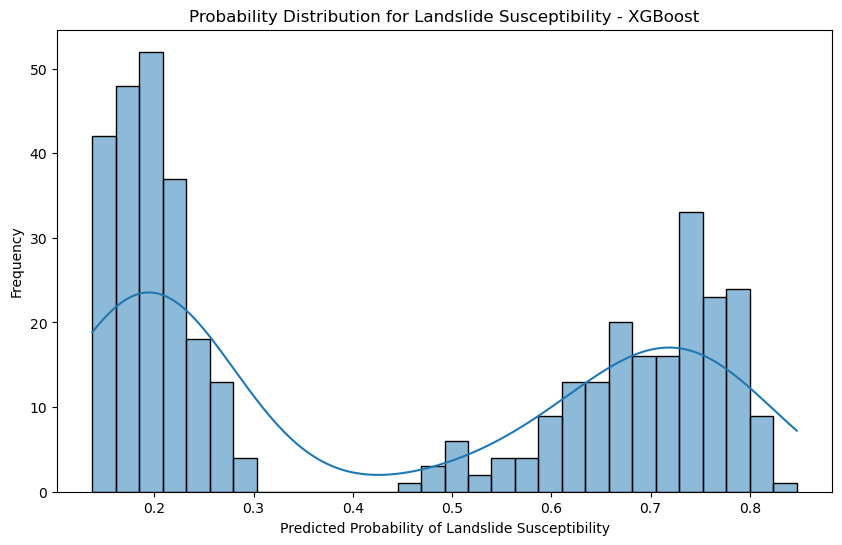

Probability Statistics for XGBoost Model:
  Mean: 0.436
  Standard Deviation: 0.258
  Min: 0.137
  Max: 0.847

[LightGBM] [Warning] Unknown parameter: use_label_encoder


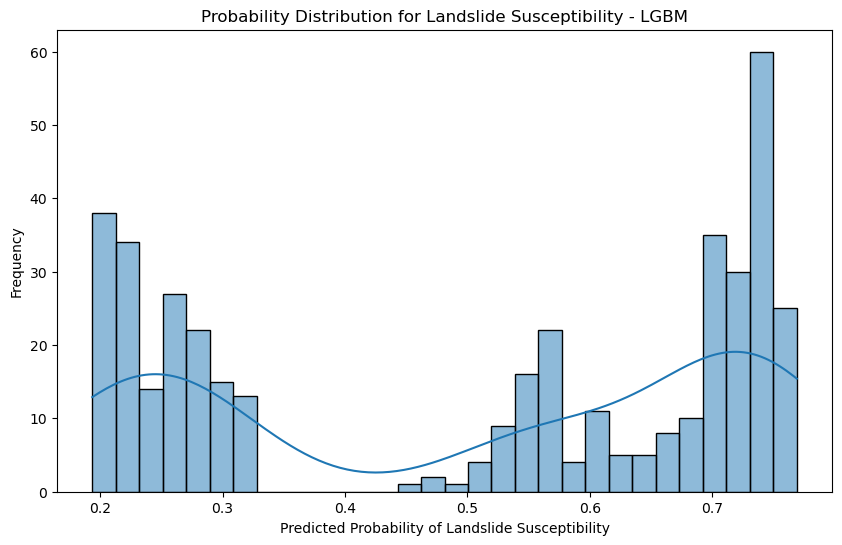

Probability Statistics for LGBM Model:
  Mean: 0.505
  Standard Deviation: 0.220
  Min: 0.194
  Max: 0.769



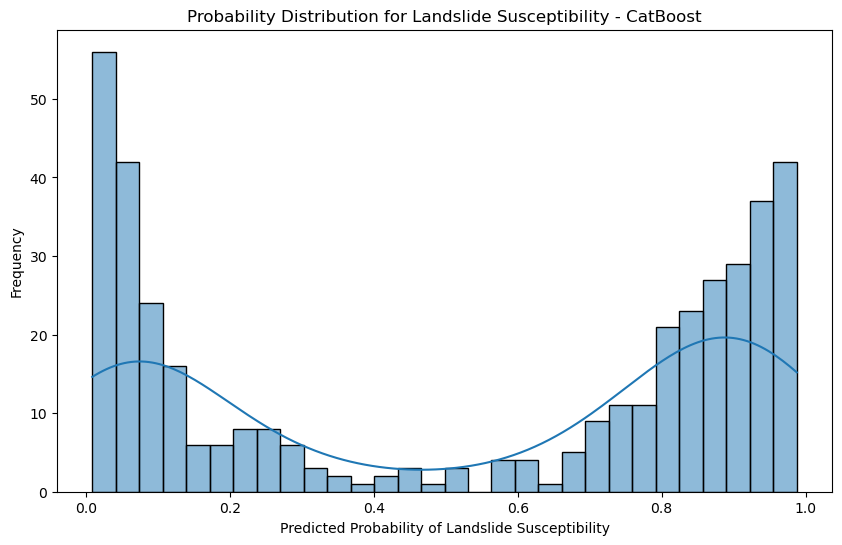

Probability Statistics for CatBoost Model:
  Mean: 0.524
  Standard Deviation: 0.388
  Min: 0.008
  Max: 0.988



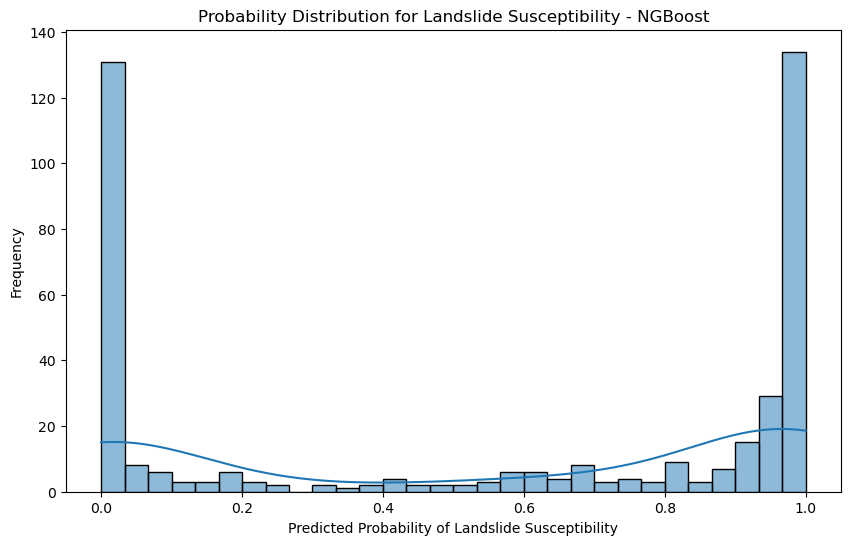

Probability Statistics for NGBoost Model:
  Mean: 0.549
  Standard Deviation: 0.442
  Min: 0.000
  Max: 1.000

Combined probability predictions have been saved to D:\Users\刘洋\Desktop\BO预测.csv


In [18]:
# 读取研究区数据
all_data = pd.read_excel(r'D:\Users\刘洋\Desktop\无坐标.xlsx')
X_all = all_data.iloc[:, 1:12].values  # 第2到12列为特征值，共计11列

# 数据标准化
scaler_all = StandardScaler()
X_all = scaler_all.fit_transform(X_all)

# 初始化用于保存所有模型预测概率的 DataFrame
probabilities_df = pd.DataFrame(index=all_data.index)

# 对研究区数据进行概率预测
for name, model in models.items():
    # 使用之前训练好的模型对研究区数据进行预测
    try:
        y_prob_all = model.predict_proba(X_all)[:, 1]  # 获取研究区数据属于“正例”（滑坡易发）的概率
    except AttributeError:
        # 如果模型未训练，进行训练（使用训练集数据）
        data1 = pd.read_excel(r'D:\Users\刘洋\Desktop\测试负2.xlsx', index_col=0)
        X = data1.iloc[:, 0:-1].values  # 取除最后一列之外的所有列作为特征
        y = data1.iloc[:, -1].values  # 最后一列为标签
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_prob_all = model.predict_proba(X_all)[:, 1]
    
    # 将预测概率添加到 DataFrame 中
    probabilities_df[name] = y_prob_all
    
    # 绘制研究区数据的概率分布
    plt.figure(figsize=(10, 6))
    sns.histplot(y_prob_all, kde=True, bins=30)
    plt.title(f'Probability Distribution for Landslide Susceptibility - {name}')
    plt.xlabel('Predicted Probability of Landslide Susceptibility')
    plt.ylabel('Frequency')
    plt.show()

    # 输出概率预测的基本统计信息
    print(f"Probability Statistics for {name} Model:")
    print(f"  Mean: {np.mean(y_prob_all):.3f}")
    print(f"  Standard Deviation: {np.std(y_prob_all):.3f}")
    print(f"  Min: {np.min(y_prob_all):.3f}")
    print(f"  Max: {np.max(y_prob_all):.3f}")
    print()

# 将所有模型的概率预测结果输出到 Excel 文件
output_path = r'D:\Users\刘洋\Desktop\BO预测.csv'
probabilities_df.to_csv(output_path)
print(f"Combined probability predictions have been saved to {output_path}")

In [19]:
# %% SHAP 解释
# 确保特征名称正确
feature_names = all_data.columns[1:12]  # 第2到12列为特征名称

# 对每个模型进行 SHAP 解释
for name, model in models.items():
    print(f"Generating SHAP explanations for model: {name}")
    
    # 使用 TreeExplainer 对树模型（XGBoost、LGBM、CatBoost）进行解释
    if name in ["XGBoost", "LGBM", "CatBoost"]:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_all)

        # 绘制 SHAP 总结图（柱状图）
        shap.summary_plot(shap_values, X_all, feature_names=feature_names, plot_type="bar", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Summary_{name}_AllData.png')
        plt.close()

        # 绘制 SHAP 散点图（按特征显示的散点图）
        if isinstance(shap_values, list):  # 检查是否有多个类别
            for i in range(len(shap_values)):
                shap.summary_plot(shap_values[i], X_all, feature_names=feature_names, plot_type="dot", show=False)
                plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Scatter_{name}_AllData_class_{i}.png')
                plt.close()
        else:
            shap.summary_plot(shap_values, X_all, feature_names=feature_names, plot_type="dot", show=False)
            plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Scatter_{name}_AllData.png')
            plt.close()

    # 使用通用的 SHAP Explainer 进行解释 (NGBoost)
    elif name == "NGBoost":
        explainer = shap.Explainer(model.predict, X_all)
        shap_values = explainer(X_all)

        # 绘制 SHAP 总结图
        shap.summary_plot(shap_values, X_all, feature_names=feature_names, plot_type="bar", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Summary_{name}_AllData.png')
        plt.close()

        # 绘制 SHAP 散点图
        shap.summary_plot(shap_values, X_all, feature_names=feature_names, plot_type="dot", show=False)
        plt.savefig(fr'D:\Users\刘洋\Desktop\SHAP_Scatter_{name}_AllData.png')
        plt.close()

print("SHAP explanations have been generated and saved for each model.")


Generating SHAP explanations for model: XGBoost


[20:43:01] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Generating SHAP explanations for model: LGBM


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Generating SHAP explanations for model: CatBoost


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Generating SHAP explanations for model: NGBoost


Permutation explainer: 412it [03:30,  1.87it/s]                         
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


SHAP explanations have been generated and saved for each model.
